## Genetic Algorithm

- This notebooks compare experiments of different selection, crossover and mutation functions
- Compares each function `best mean fitness` and `run time` by running an experiment 10 times
- Plot fitness results for each run using matplotlib 

- Selection methods:
    - Roulette Stochastic Acceptance
    - Roulette wheel selection
    - Tournament selection

- Crossover methods:
    - Simulated Binary Crossover
    - uniform Crossover
    - single point Crossover

- Mutation methods:
    - Gaussian
    - uniform
    - swap


In [8]:
import random
import numpy as np
import math
import time
import matplotlib.pyplot as plt

## Parameters

In [ ]:
# === Parameters ===
POP_SIZE = 50
GENES = 8
GENERATIONS = 30
ELITE_COUNT = 3
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.1
INITIAL_MUTATION_STD = 0.5  # High initial value
MUTATION_DECAY = 0.95       # Decay factor per generation
INITIAL_SBX_ETA = 2
SBX_ETA_GROWTH = 1.05       # SBX eta increases each generation

# === Fixed input individuals for blend ===
INPUT_A = [0.9, 0.9, 0.0, 0.8, 0.2, 0.9, 0.7, 0.7]
INPUT_B = [0.8, 0.2, 1.0, 0.3, 0.9, 0.4, 0.6, 0.3]

## Fitness

In [2]:
# === Fitness Function ===
def fitness(candidate):
    emergence = [c - max(a, b) for c, a, b in zip(candidate, INPUT_A, INPUT_B)]
    emergence = [max(0, e) for e in emergence]  # clamp negative emergence to 0
    contributions = [min(a, b) * e for a, b, e in zip(INPUT_A, INPUT_B, emergence)]
    total = sum(contributions)
    return min(total / GENES, 1.0)

## Initialization

In [3]:
# === Initialization ===
def initialize_population():
    return [np.random.uniform(0, 1, GENES).tolist() for _ in range(POP_SIZE)]


## Selection

In [ ]:
#  Roulette Stochastic Acceptance ===
def roulette_stochastic_acceptance(population, fitnesses):
    w_max = max(fitnesses)
    while True:
        i = random.randint(0, len(population) - 1)
        if random.random() < fitnesses[i] / w_max:
            return population[i]
    

In [ ]:
# roulette wheel selection
def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    r = random.uniform(0, total_fitness)
    cumulative = 0
    for ind, fit in zip(population, fitnesses):
        cumulative += fit
        if cumulative >= r:
            return ind
    return population[-1] 

In [ ]:
# tournament selection
def tournament_selection(population, fitnesses, tournament_size=3):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_idx = max(selected_indices, key=lambda idx: fitnesses[idx])
    return population[best_idx]

## Crossover

In [70]:
# Simulated Binary Crossover (Adaptive Eta) 
def sbx_crossover(p1, p2, eta):
    if random.random() > CROSSOVER_RATE:
        return p1[:], p2[:]

    child1, child2 = [], []
    for x1, x2 in zip(p1, p2):
        if random.random() <= 0.5:
            if abs(x1 - x2) > 1e-14:
                x1, x2 = min(x1, x2), max(x1, x2)
                rand = random.random()
                beta = 1.0 + (2.0 * (x1) / (x2 - x1))
                alpha = 2.0 - beta ** -(eta + 1)
                if rand <= 1.0 / alpha:
                    betaq = (rand * alpha) ** (1.0 / (eta + 1))
                else:
                    betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1))
                c1 = 0.5 * ((x1 + x2) - betaq * (x2 - x1))
                c2 = 0.5 * ((x1 + x2) + betaq * (x2 - x1))
                child1.append(min(max(c1, 0.0), 1.0))
                child2.append(min(max(c2, 0.0), 1.0))
            else:
                child1.append(x1)
                child2.append(x2)
        else:
            child1.append(x1)
            child2.append(x2)
    return child1, child2


In [30]:
def uniform_crossover(p1, p2):
    child1, child2 = [], []
    for x1, x2 in zip(p1, p2):
        if random.random() < 0.5:
            child1.append(x1)
            child2.append(x2)
        else:
            child1.append(x2)
            child2.append(x1)
    return child1, child2

In [31]:
def single_point_crossover(p1, p2):
    if len(p1) < 2:
        return p1[:], p2[:]
    point = random.randint(1, len(p1) - 1)
    child1 = p1[:point] + p2[point:]
    child2 = p2[:point] + p1[point:]
    return child1, child2

## Mutation

In [ ]:
# Guassian Mutation 
def mutate(individual, mutation_std):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            individual[i] += random.gauss(0, mutation_std)
            individual[i] = min(max(individual[i], 0), 1)  
    return individual

In [39]:
def uniform_mutation(individual, mutation_std=None):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            individual[i] = random.uniform(0, 1)
    return individual

In [40]:
def swap_mutation(individual, mutation_std=None):
    if random.random() < MUTATION_RATE and len(individual) > 1:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

## Experiment

### main loop

In [ ]:
def run_experiments(selection_method='roulette_stochastic', crossover_method='sbx', mutation_method='gaussian', runs=10):
    best_fitnesses = []
    for _ in range(runs):
        population = initialize_population()
        mutation_std = INITIAL_MUTATION_STD
        sbx_eta = INITIAL_SBX_ETA
        for gen in range(GENERATIONS):
            fitnesses = [fitness(ind) for ind in population]
            elites = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)[:ELITE_COUNT]
            new_population = [ind for ind, _ in elites]
            while len(new_population) < POP_SIZE:
                if selection_method == "roulette_stochastic":
                    parent1 = roulette_stochastic_acceptance(population, fitnesses)
                    parent2 = roulette_stochastic_acceptance(population, fitnesses)
                elif selection_method == "roulette_wheel":
                    parent1 = roulette_wheel_selection(population, fitnesses)
                    parent2 = roulette_wheel_selection(population, fitnesses)
                elif selection_method == "tournament":
                    parent1 = tournament_selection(population, fitnesses)
                    parent2 = tournament_selection(population, fitnesses)
                else:
                    raise ValueError("Unknown selection method")
                if crossover_method == 'sbx':
                    child1, child2 = sbx_crossover(parent1, parent2, eta=sbx_eta)
                elif crossover_method == 'uniform':
                    child1, child2 = uniform_crossover(parent1, parent2)
                elif crossover_method == 'single_point':
                    child1, child2 = single_point_crossover(parent1, parent2)
                else:
                    raise ValueError("Unknown crossover method")
                if mutation_method == 'gaussian':
                    new_population.extend([mutate(child1, mutation_std), mutate(child2, mutation_std)])
                elif mutation_method == 'uniform':
                    new_population.extend([uniform_mutation(child1), uniform_mutation(child2)])
                elif mutation_method == 'swap':
                    new_population.extend([swap_mutation(child1), swap_mutation(child2)])
                else:
                    raise ValueError("Unknown mutation method")
            population = new_population[:POP_SIZE]
            mutation_std *= MUTATION_DECAY
            sbx_eta *= SBX_ETA_GROWTH
        final_fitnesses = [fitness(ind) for ind in population]
        best = max(final_fitnesses)
        best_fitnesses.append(best)
    return best_fitnesses



## Selection Experiment

roulette_stochastic Mean Best Fitness = 0.0611, Total Time = 0.2916 sec, Mean Time = 0.0292 sec 

roulette_wheel Mean Best Fitness = 0.0611, Total Time = 0.3335 sec, Mean Time = 0.0334 sec 

tournament Mean Best Fitness = 0.0613, Total Time = 0.2985 sec, Mean Time = 0.0299 sec 



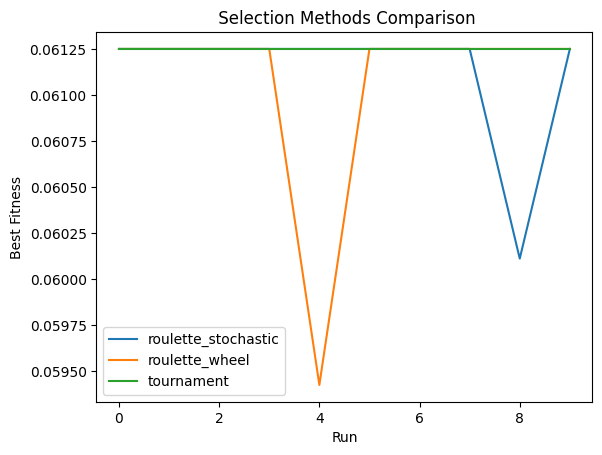

In [66]:
selection_methods = ["roulette_stochastic", "roulette_wheel", "tournament"]
for select in selection_methods:
    start = time.time()
    results = run_experiments(selection_method=select, runs=10)
    elapsed = time.time() - start
    print(f"{select} Mean Best Fitness = {np.mean(results):.4f}, Total Time = {elapsed:.4f} sec, Mean Time = {elapsed/10:.4f} sec \n")
    plt.plot(results, label=select)
plt.legend()
plt.xlabel("Run")
plt.ylabel("Best Fitness")
plt.title(" Selection Methods Comparison")
plt.show()


## Crossover Experiment

tournament Mean Best Fitness = 0.0612, Total Time = 0.3347 sec, Mean Time = 0.0335 sec 

tournament Mean Best Fitness = 0.0608, Total Time = 0.2267 sec, Mean Time = 0.0227 sec 

tournament Mean Best Fitness = 0.0596, Total Time = 0.2204 sec, Mean Time = 0.0220 sec 



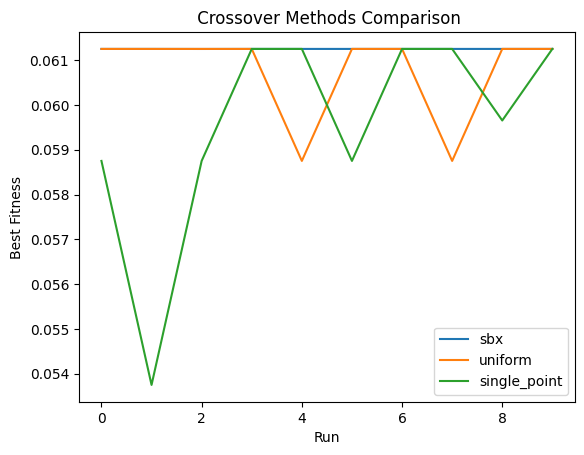

In [ ]:
crossover_methods = ["sbx", "uniform", "single_point"]
for crossover in crossover_methods:
    start = time.time()
    results = run_experiments(crossover_method=crossover, runs=10)
    elapsed = time.time() - start
    print(f"{crossover} Mean Best Fitness = {np.mean(results):.4f}, Total Time = {elapsed:.4f} sec, Mean Time = {elapsed/10:.4f} sec \n")
    plt.plot(results, label=crossover)
plt.legend()
plt.xlabel("Run")
plt.ylabel("Best Fitness")
plt.title(" Crossover Methods Comparison")
plt.show()


## Mutation Experiment

gaussian: Mean Best Fitness = 0.0612, Total Time = 0.3626 sec, Mean Time = 0.0363 sec

uniform: Mean Best Fitness = 0.0598, Total Time = 0.2939 sec, Mean Time = 0.0294 sec

swap: Mean Best Fitness = 0.0612, Total Time = 0.2810 sec, Mean Time = 0.0281 sec



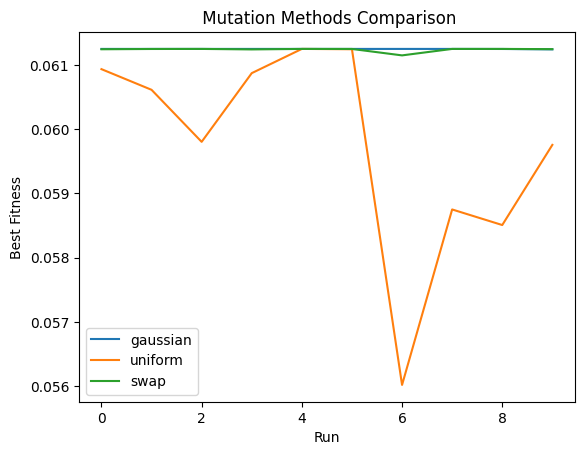

In [58]:
mutation_methods = ["gaussian", "uniform", "swap"]
for mutation in mutation_methods:
    start = time.time()
    results = run_experiments( mutation_method=mutation, runs=10)
    elapsed = time.time() - start
    print(f"{mutation}: Mean Best Fitness = {np.mean(results):.4f}, Total Time = {elapsed:.4f} sec, Mean Time = {elapsed/10:.4f} sec\n")
    plt.plot(results, label=mutation)
plt.legend()
plt.xlabel("Run")
plt.ylabel("Best Fitness")
plt.title(" Mutation Methods Comparison")
plt.show()